# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, MomentumPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Data

## Universe: KOSPI200

In [3]:
k200 = DataManager(
    universe = 'kospi200',
    file = 'kospi200_prices_240707lst.csv',
    path = path_data
)
k200.upload()

200 assets from 2000-03-06 to 2024-07-05 uploaded.
df_prices updated


In [4]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [5]:
cond = df_k200.notna().sum(axis=1) > 170
df_k200 = df_k200.loc[cond].dropna(axis=1)
df_k200.columns.size

171

## Ratios

In [6]:
WidgetUniverse

In [7]:
file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)

Financial ratios of 171 stocks from 2017-05-31 to 2024-09-30 loaded


In [8]:
start = df_k200.index.min()
#tickers = df_k200.columns.to_list()[:3]
tickers = df_k200.columns.to_list()

fr.download(tickers, start) if WidgetUniverse.values(0) else None

In [9]:
fr.df_ratios

BPS    PER   PBR     EPS   DIV    DPS
ticker date                                                 
005930 2017-05-31  1156530  14.43  1.97  157967  1.25  28500
       2017-06-30  1156530  14.14  1.93  157967  1.28  28500
       2017-07-31  1156530  14.95  2.04  157967  1.21  28500
       2017-08-31  1156530  15.38  2.10  157967  1.17  28500
       2017-09-30  1156530  14.71  2.01  157967  1.23  28500
...                    ...    ...   ...     ...   ...    ...
000670 2024-05-31  2216785   0.00  0.18       0  2.48  10000
       2024-06-30  2216785   0.00  0.17       0  2.66  10000
       2024-07-31  2216785   0.00  0.15       0  2.95  10000
       2024-08-31  2216785   0.00  0.14       0  3.17  10000
       2024-09-30  2216785   0.00  0.14       0  3.23  10000

[15219 rows x 6 columns]

In [10]:
fr.calc_rank(metrics='PER', date='start', topn=None)

Ranking score of PER on 2017-05-31


ticker
081660    0.000000
002710    0.006667
015760    0.013333
000270    0.020000
006650    0.026667
            ...   
009420    0.973333
009150    0.980000
008930    0.986667
011070    0.993333
241560    1.000000
Name: PER, Length: 151, dtype: float64

In [11]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2017-05-31    1.170513
        2017-06-30    1.133791
        2017-07-31    1.197392
        2017-08-31    1.200673
        2017-09-30    1.155763
                        ...   
000670  2024-05-31    0.011765
        2024-06-30    0.011765
        2024-07-31    0.005882
        2024-08-31    0.000000
        2024-09-30    0.000000
Name: PER, Length: 15219, dtype: float64

## Reshape for backtest

In [12]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

PER interpolated from 2017-05-10 to 2024-07-05
PBR interpolated from 2017-05-10 to 2024-07-05


# Backtest

## Example

In [48]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [49]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [50]:
#bm.align_period(df_k200, axis=0, fill_na=True, print_msg2=True)

from pf_utils import get_date_minmax

df_aligned = df_k200
date_format = '%Y-%m-%d'
#dts = [x.strftime(date_format) for x in (df_aligned.index.min(), df_aligned.index.max())]
dts = get_date_minmax(df_aligned, date_format)

msg1 = f"period reset: {' ~ '.join(dts)}"
print(msg1)

period reset: 2017-05-10 ~ 2024-07-05


In [51]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [52]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [53]:
select = 'f-ratio'
kwargs_build = dict(
    name=f'{select}', select =select, weigh='Equally', 
    n_assets=5, freq='Y', lookback=5,
    df_ratio=df_ratio, ratio_descending=True
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, f-ratio


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Returning stats


,KODEX200,f-ratio
start,2017-05-09,2017-05-09
end,2024-07-05,2024-07-05
total_return,0.545298,0.393314
cagr,0.062699,0.047437
calmar,0.164837,0.087122
max_drawdown,-0.38037,-0.544485
avg_drawdown,-0.04033,-0.085891
avg_drawdown_days,78.46875,126.75
daily_vol,0.18247,0.29995
daily_sharpe,0.432459,0.307699


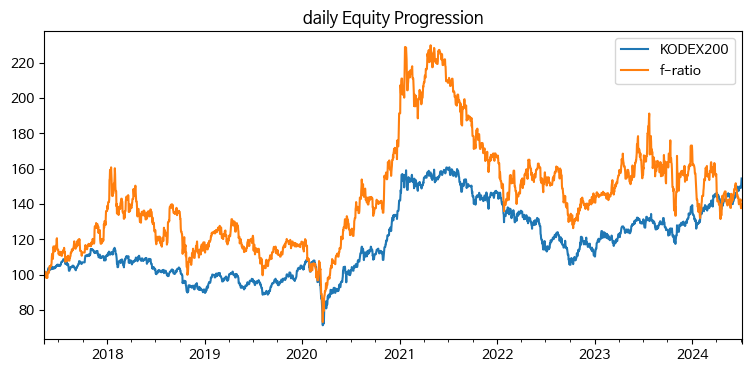

In [54]:
bm.run(figsize=(9,4), stats_sort_by='monthly_sharpe')

In [55]:
bm.portfolios

0) KODEX200
1) f-ratio

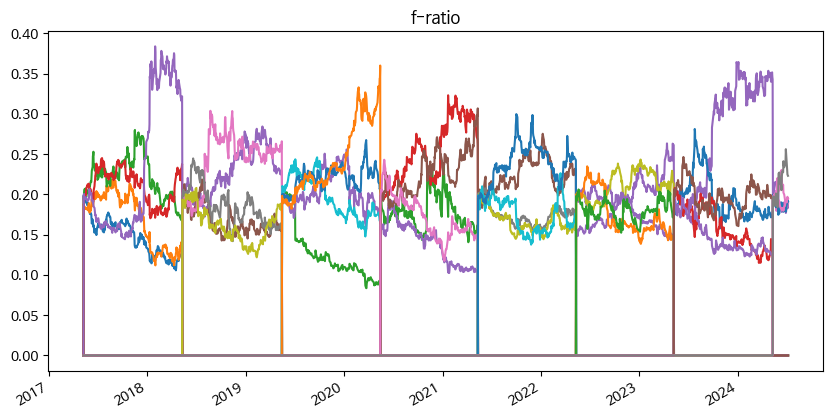

In [56]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [13]:
n_test = 500
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test:]

In [14]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [15]:
bm = BacktestManager(df_train, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [16]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [17]:
from itertools import product

params = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER', 'PBR'],
    p_ast = [5, 10, 20, 30],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10, 20, 30, 60]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}/lb{x[3]}',
             'df_ratio':fratios_dict[x[0]], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)
bm.build_batch(*kwa_list, **kwargs_build)

In [18]:
df_res = bm.run(stats_sort_by='monthly_sharpe', plot=False)
df_res.iloc[:, :5]

Backtesting 145 strategies: KODEX200, PER:a5/f130/lb0, ... , PBR:a30/f500/lb60


100%|█████████████████████████████████████████████████████████████| 145/145 [02:39<00:00,  1.10s/it]


Returning stats


,PER:a5/f500/lb0,PER:a5/f500/lb5,PER:a5/f500/lb10,PER:a5/f500/lb30,PER:a5/f130/lb10
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24
total_return,1.869966,1.869966,1.501494,1.243397,1.296179
cagr,0.228393,0.228393,0.195896,0.170755,0.176079
calmar,0.544341,0.544341,0.46689,0.37943,0.335116
max_drawdown,-0.419577,-0.419577,-0.419577,-0.450031,-0.525428
avg_drawdown,-0.054061,-0.054061,-0.048832,-0.056934,-0.045914
avg_drawdown_days,34.28,34.28,36.808511,32.679245,30.696429
daily_vol,0.267809,0.267809,0.263329,0.318648,0.25059
daily_sharpe,0.92066,0.92066,0.827453,0.665237,0.788417


In [26]:
df_res.loc[metrics2].iloc[:,:7]

,PER:a5/f500/lb0,PER:a5/f500/lb5,PER:a5/f500/lb10,PER:a5/f500/lb30,PER:a5/f130/lb10,PER:a5/f130/lb0,PER:a5/f130/lb5
total_return,1.869966,1.869966,1.501494,1.243397,1.296179,1.286074,1.286074
cagr,0.228393,0.228393,0.195896,0.170755,0.176079,0.175068,0.175068
monthly_vol,0.267968,0.267968,0.259743,0.24192,0.274186,0.273472,0.273472
monthly_sharpe,0.876514,0.876514,0.791098,0.744081,0.699999,0.697944,0.697944
max_drawdown,-0.419577,-0.419577,-0.419577,-0.450031,-0.525428,-0.524978,-0.524978
avg_drawdown,-0.054061,-0.054061,-0.048832,-0.056934,-0.045914,-0.047307,-0.047307
avg_drawdown_days,34.28,34.28,36.808511,32.679245,30.696429,31.981481,31.981481


In [27]:
bm.portfolios

0) KODEX200
1) PER:a5/f130/lb0
2) PER:a5/f130/lb5
3) PER:a5/f130/lb10
4) PER:a5/f130/lb20
5) PER:a5/f130/lb30
6) PER:a5/f130/lb60
7) PER:a5/f250/lb0
8) PER:a5/f250/lb5
9) PER:a5/f250/lb10
10) PER:a5/f250/lb20
11) PER:a5/f250/lb30
12) PER:a5/f250/lb60
13) PER:a5/f500/lb0
14) PER:a5/f500/lb5
15) PER:a5/f500/lb10
16) PER:a5/f500/lb20
17) PER:a5/f500/lb30
18) PER:a5/f500/lb60
19) PER:a10/f130/lb0
20) PER:a10/f130/lb5
21) PER:a10/f130/lb10
22) PER:a10/f130/lb20
23) PER:a10/f130/lb30
24) PER:a10/f130/lb60
25) PER:a10/f250/lb0
26) PER:a10/f250/lb5
27) PER:a10/f250/lb10
28) PER:a10/f250/lb20
29) PER:a10/f250/lb30
30) PER:a10/f250/lb60
31) PER:a10/f500/lb0
32) PER:a10/f500/lb5
33) PER:a10/f500/lb10
34) PER:a10/f500/lb20
35) PER:a10/f500/lb30
36) PER:a10/f500/lb60
37) PER:a20/f130/lb0
38) PER:a20/f130/lb5
39) PER:a20/f130/lb10
40) PER:a20/f130/lb20
41) PER:a20/f130/lb30
42) PER:a20/f130/lb60
43) PER:a20/f250/lb0
44) PER:a20/f250/lb5
45) PER:a20/f250/lb10
46) PER:a20/f250/lb20
47) PER:a20/f250/lb

In [29]:
pf_list = [0, 1, 3, 4, 13, 15, 16]
#pf_list = list(range(7))
#bm.get_stats(pf_list, sort_by='monthly_sharpe')
bm.get_stats(pf_list)

,KODEX200,PER:a5/f130/lb0,PER:a5/f130/lb10,PER:a5/f130/lb20,PER:a5/f500/lb0,PER:a5/f500/lb10,PER:a5/f500/lb20
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24
total_return,0.166881,1.286074,1.296179,1.229889,1.869966,1.501494,1.25775
cagr,0.03057,0.175068,0.176079,0.169376,0.228393,0.195896,0.172213
calmar,0.08037,0.333477,0.335116,0.322635,0.544341,0.46689,0.323109
max_drawdown,-0.38037,-0.524978,-0.525428,-0.524978,-0.419577,-0.419577,-0.532987
avg_drawdown,-0.038662,-0.047307,-0.045914,-0.049667,-0.054061,-0.048832,-0.049558
avg_drawdown_days,55.28125,31.981481,30.696429,34.64,34.28,36.808511,39.863636
daily_vol,0.187578,0.251767,0.25059,0.251217,0.267809,0.263329,0.269621
daily_sharpe,0.258084,0.782393,0.788417,0.763747,0.92066,0.827453,0.738391


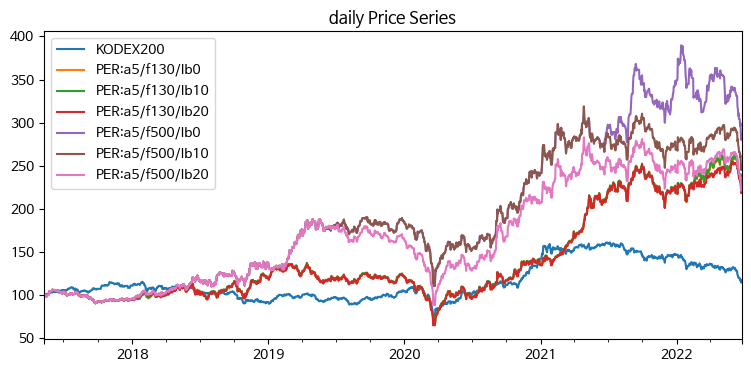

In [30]:
_ = bm.plot(pf_list, figsize=(9,4))

### Validation

In [42]:
bm = BacktestManager(df_test, **kwargs_bm)
bm.benchmark_ticker()

running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [32]:
from itertools import product

params = dict(
    p_fr = ['PER'],
    p_ast = [5],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}/lb{x[3]}',
              'df_ratio':fratios_dict[x[0]], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)

bm.build_batch(*kwa_list, **kwargs_build)
df_res = bm.run(stats_sort_by='monthly_sharpe', plot=False)

Backtesting 145 strategies: KODEX200, PER:a5/f130/lb0, ... , PBR:a30/f500/lb60


100%|█████████████████████████████████████████████████████████████| 145/145 [00:08<00:00, 16.66it/s]


Returning stats


In [33]:
df_res.iloc[:, :5]

,PER:a5/f500/lb0,PER:a5/f500/lb5,PER:a5/f500/lb10,PER:a5/f500/lb30,PER:a5/f130/lb10
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24
total_return,1.869966,1.869966,1.501494,1.243397,1.296179
cagr,0.228393,0.228393,0.195896,0.170755,0.176079
calmar,0.544341,0.544341,0.46689,0.37943,0.335116
max_drawdown,-0.419577,-0.419577,-0.419577,-0.450031,-0.525428
avg_drawdown,-0.054061,-0.054061,-0.048832,-0.056934,-0.045914
avg_drawdown_days,34.28,34.28,36.808511,32.679245,30.696429
daily_vol,0.267809,0.267809,0.263329,0.318648,0.25059
daily_sharpe,0.92066,0.92066,0.827453,0.665237,0.788417


## Cross-validation

In [34]:
n_test = 500
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test:]

In [35]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [36]:
bm = BacktestManager(df_test, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [39]:
from itertools import product

params = dict(
    p_fr = ['PER'],
    p_ast = [5, 10],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}/lb{x[3]}',
             'df_ratio':fratios_dict[x[0]], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)

bm.build_batch(*kwa_list, **kwargs_build)

In [40]:
df_res = bm.cross_validate(n_sample=10)

Cross-validating 18 strategies: PER:a5/f130/lb0, PER:a5/f130/lb10, ... , PER:a10/f500/lb10


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]


In [88]:
m = ['cagr', 'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 'monthly_vol', 'monthly_sharpe']
df_res.T[m]

,cagr,max_drawdown,avg_drawdown,avg_drawdown_days,monthly_vol,monthly_sharpe
PER:a5/f130/lb0,0.12 ± 0.070,-0.18 ± 0.014,-0.07 ± 0.016,44.17 ± 11.123,0.22 ± 0.050,0.59 ± 0.277
PER:a5/f130/lb10,0.11 ± 0.069,-0.19 ± 0.028,-0.07 ± 0.018,49.33 ± 16.612,0.21 ± 0.052,0.53 ± 0.267
PER:a5/f250/lb0,0.11 ± 0.053,-0.20 ± 0.025,-0.07 ± 0.017,51.98 ± 18.663,0.23 ± 0.062,0.53 ± 0.203
PER:a5/f250/lb10,0.10 ± 0.045,-0.21 ± 0.033,-0.07 ± 0.017,54.39 ± 17.900,0.23 ± 0.059,0.51 ± 0.158
PER:a5/f500/lb0,0.03 ± 0.029,-0.22 ± 0.031,-0.07 ± 0.018,68.55 ± 21.359,0.21 ± 0.065,0.23 ± 0.166
PER:a5/f500/lb10,0.02 ± 0.040,-0.23 ± 0.034,-0.07 ± 0.019,68.20 ± 19.808,0.21 ± 0.064,0.18 ± 0.221
PER:a5/f130/lb5,0.11 ± 0.070,-0.19 ± 0.027,-0.07 ± 0.015,49.56 ± 16.537,0.22 ± 0.052,0.54 ± 0.279
PER:a5/f250/lb5,0.11 ± 0.051,-0.21 ± 0.024,-0.07 ± 0.017,53.05 ± 17.713,0.23 ± 0.061,0.53 ± 0.187
PER:a5/f500/lb5,0.03 ± 0.029,-0.22 ± 0.030,-0.07 ± 0.018,70.08 ± 20.264,0.21 ± 0.063,0.23 ± 0.166
PER:a10/f130/lb0,0.04 ± 0.028,-0.18 ± 0.026,-0.06 ± 0.011,63.67 ± 16.357,0.16 ± 0.052,0.29 ± 0.183


In [ ]:
#bm.cv_strategies

In [ ]:
#pf_list = list(range(6))
#bm.cross_validate(pf_list, n_sample=10)

# Transaction

In [42]:
df_ratio = fratios_dict['PER']

In [43]:
kw_per = dict(
    name='PER',
    method_select='f-ratio',
    sort_ascending=True,
    lookback=0, # days
    df_additional=df_ratio,
    method_weigh='equally', 
)

kwargs = dict(
    #file='pf_k200_per.csv',
    file='test_per.csv',
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
    **kw_per
)

pf_per = MomentumPortfolio(df_k200, **kwargs)

running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [44]:
pf_per.record

In [45]:
pf_per.valuate()

ERROR: No transaction record


In [46]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [48]:
kwargs_trs = dict(
    n_assets = 5,
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)
kw_liq = dict(
    #assets_to_sell= {'489790':34500},
    #assets_to_sell= '489790',
    #hold= True
)
df_trs = pf_per.transaction_pipeline(**kwargs_trs, **kw_liq)
df_trs.loc[df_trs.index.get_level_values(0).unique()[-2:]]

Liquidation set to None
5 assets selected by Financial Ratio from 2023-12-28 to 2023-12-28
Weights of assets determined by Equal weights.
Mean absolute error of weights: 1 %
Portfolio value 4,679,820, Profit 18.7% on 2024-07-05
Set save=True to save transaction record


name  price  transaction  net weight weight*
date       asset                                                 
2023-12-28 011200     HMM  19580           40   40  0.200  0.1987
           036460  한국가스공사  24700           32   32  0.200  0.2006
           016380    KG스틸   8900           89   89  0.200  0.2010
           000880      한화  25750           31   31  0.200  0.2025
           078930      GS  40900           19   19  0.200  0.1972